In [3]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.datasets.mnist import load_data
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.optimizers import Adam
import wandb
from wandb.integration.keras import WandbMetricsLogger

# Configuración de warnings y matplotlib
warnings.filterwarnings("ignore")
%matplotlib inline

In [5]:
# Iniciar sesión en Weights & Biases
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: steestor (steestor-universitat-polit-cnica-de-val-ncia). Use `wandb login --relogin` to force relogin


True

In [7]:
# Cargar el conjunto de datos MNIST
(X_train, y_train), (X_test, y_test) = load_data()

# Obtener el tamaño del conjunto de entrenamiento
n_train_size = X_train.shape[0]

In [9]:
print("-"*50)
print("Training data X shape: {}".format(X_train.shape))
print("Training data y shape: {}".format(y_train.shape))
print("-"*50)
print("Test data X shape: {}".format(X_test.shape))
print("Test data y shape: {}".format(y_test.shape))
print("-"*50)

--------------------------------------------------
Training data X shape: (60000, 28, 28)
Training data y shape: (60000,)
--------------------------------------------------
Test data X shape: (10000, 28, 28)
Test data y shape: (10000,)
--------------------------------------------------


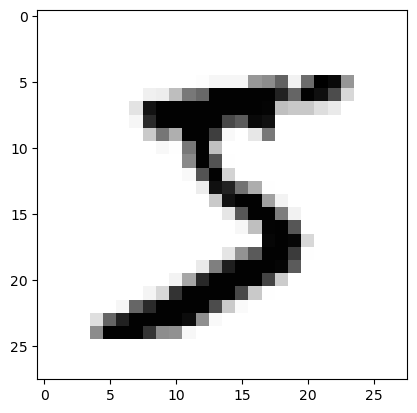

In [11]:
i_image = 0
plt.imshow(X_train[i_image,:,:], cmap="Greys")
plt.show()

In [13]:
# Normalizar los valores de píxeles dividiendo por 255
# Esto convierte los valores de 0-255 a 0-1
X_train = X_train/255
X_test = X_test/255

In [15]:
# Reshape de los datos para que sean compatibles con la CNN
# -1 significa "mantener el número de muestras original"
# 28,28 son las dimensiones de la imagen
# 1 es el número de canales (escala de grises)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Preparar las etiquetas
# Concatenar los datos de entrenamiento y prueba
y = np.concatenate([y_train, y_test], axis=0)
# Convertir a one-hot encoding con 10 clases (dígitos 0-9)
y = tf.keras.utils.to_categorical(y, 10)

In [17]:
# Separar de nuevo en conjuntos de entrenamiento y prueba
y_train = y[:n_train_size,:]
y_test = y[n_train_size:,:]

In [19]:
# Definir la probabilidad de dropout
drop_prob = 0.5

# Crear un modelo secuencial
model = Sequential()

# Primera capa convolucional + pooling
model.add(Conv2D(input_shape=(28,28,1), 
                 filters=32, 
                 kernel_size=(3,3), 
                 padding="same", 
                 activation="relu", 
                 name="Conv_1"))
model.add(MaxPooling2D(pool_size=2))

# Mostrar las formas de salida de cada capa
model.compute_output_shape(input_shape=(None,28,28,1))

(None, 14, 14, 32)

In [21]:
# Segunda capa convolucional + pooling
model.add(Conv2D(filters=64, 
                 kernel_size=(5,5), 
                 activation="relu", 
                 padding="same", 
                 name="Conv_2"))
model.add(MaxPooling2D(pool_size=2))

model.compute_output_shape(input_shape=(None,28,28,1))

(None, 7, 7, 64)

In [23]:
# Aplanar los datos para las capas densas
model.add(Flatten())

# Capas densas (fully connected)
model.add(Dense(1024, activation="relu"))
model.add(Dropout(rate=drop_prob))
model.add(Dense(10, activation="softmax"))

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv_1 (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv_2 (Conv2D)                      │ (None, 14, 14, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       3,212,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,274,122 (12.49 MB)

 Trainable params: 3,274,122 (12.49 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Inicializar el experimento en Weights & Biases
run = wandb.init(project = "MNIST project",
                name = "Prueba 4",
                config = {
                    "learning_rate": 0.001,
                    "epochs": 10,
                    "batch_size": 200,
                    "loss_function": "categorical_crossentropy",
                    "metrics": "accuracy",
                    "architecture": "Conv2D(32(5x5))xMaxpooling(2x2)xConv2D(64(3x3))xMaxpooling(5x5)xDense(1024)xDropout(0.5)xDense(10)",
                    "dataset": "MNIST"
                })

# Obtener la configuración de wandb
config = wandb.config

# Compilar el modelo
model.compile(optimizer = Adam(learning_rate=config.learning_rate), 
             loss=config.loss_function, 
             metrics=[config.metrics])

# Configurar el logger de métricas de Weights & Biases
callbacks = [WandbMetricsLogger()]

# Entrenar el modelo
resumen = model.fit(X_train, y_train,
                   epochs = config.epochs,
                   batch_size = config.batch_size,
                   validation_split=0.2,
                   callbacks = callbacks)

# Finalizar el experimento
run.finish()

Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 43s 170ms/step - accuracy: 0.9991 - loss: 0.0026 - val_accuracy: 0.9918 - val_loss: 0.0463
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 63s 265ms/step - accuracy: 0.9987 - loss: 0.0038 - val_accuracy: 0.9916 - val_loss: 0.0451
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 51s 131ms/step - accuracy: 0.9993 - loss: 0.0024 - val_accuracy: 0.9912 - val_loss: 0.0586
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 44s 183ms/step - accuracy: 0.9983 - loss: 0.0046 - val_accuracy: 0.9923 - val_loss: 0.0466
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 61s 252ms/step - accuracy: 0.9994 - loss: 0.0017 - val_accuracy: 0.9922 - val_loss: 0.0467
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 42s 177ms/step - accuracy: 0.9993 - loss: 0.0019 - val_accuracy: 0.9912 - val_loss: 0.0437
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 60s 248ms/step - accuracy: 0.9991 - loss: 0.0022 - val_accuracy: 0.9911 - val_loss: 0.0491
Epoch 8/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 45s 189ms/step - accuracy: 0.9990 - loss: 0

epoch/accuracy,▃▁▇▂▇█▆▆▃▇
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,▆█▃█▂▁▂▃▅▄
epoch/val_accuracy,▃▂▁▄▄▁▁▇▅█
epoch/val_loss,▃▃█▃▃▂▄▃▄▁
epoch/accuracy,0.99921
epoch/epoch,9
epoch/learning_rate,0.001
epoch/loss,0.00289
epoch/val_accuracy,0.99375


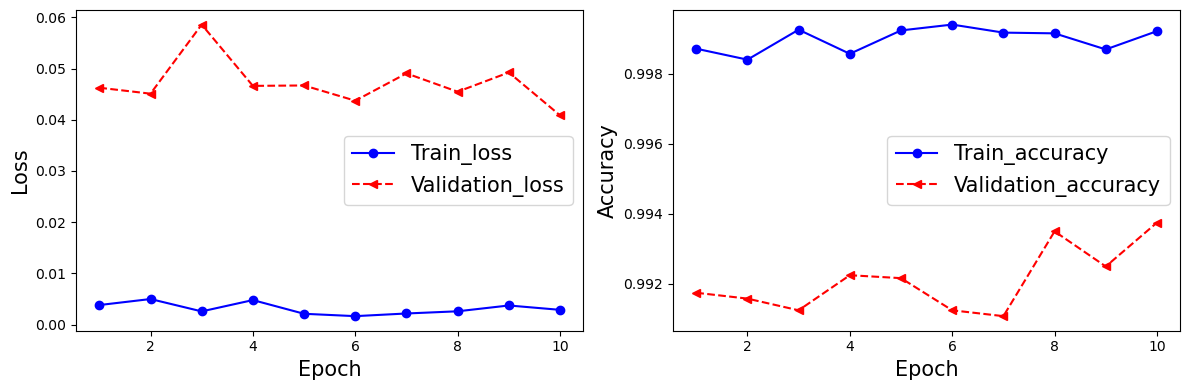

In [31]:
# Terminar el experimento de wandb
run.finish()

# Obtener el histórico de entrenamiento
hist = resumen.history

# Crear array para el eje x (épocas)
x_arr = np.arange(len(hist["loss"])) + 1

# Crear figura con dos subplots
fig = plt.figure(figsize=(12,4))

# Primer subplot: Pérdida (Loss)
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, hist["loss"], "-o", label="Train_loss", color="b")
ax.plot(x_arr, hist["val_loss"], "--<", label="Validation_loss", color="r")
ax.set_xlabel("Epoch", size=15)
ax.set_ylabel("Loss", size=15)
ax.legend(fontsize=15)

# Segundo subplot: Precisión (Accuracy)
ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, hist["accuracy"], "-o", label="Train_accuracy", color="b")
ax.plot(x_arr, hist["val_accuracy"], "--<", label="Validation_accuracy", color="r")
ax.set_xlabel("Epoch", size=15)
ax.set_ylabel("Accuracy", size=15)
ax.legend(fontsize=15)

# Mostrar la figura
plt.tight_layout()
plt.show()

In [32]:
# Realizar predicciones sobre el conjunto de prueba
preds = model.predict(X_test)

# Mostrar la forma (shape) de las predicciones
print(preds.shape)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
(10000, 10)


In [33]:
# Convertir probabilidades a predicciones de clase usando argmax
pd = tf.argmax(preds, axis=1)

# Mostrar la forma (shape) de las predicciones finales
print(pd.shape)

(10000,)


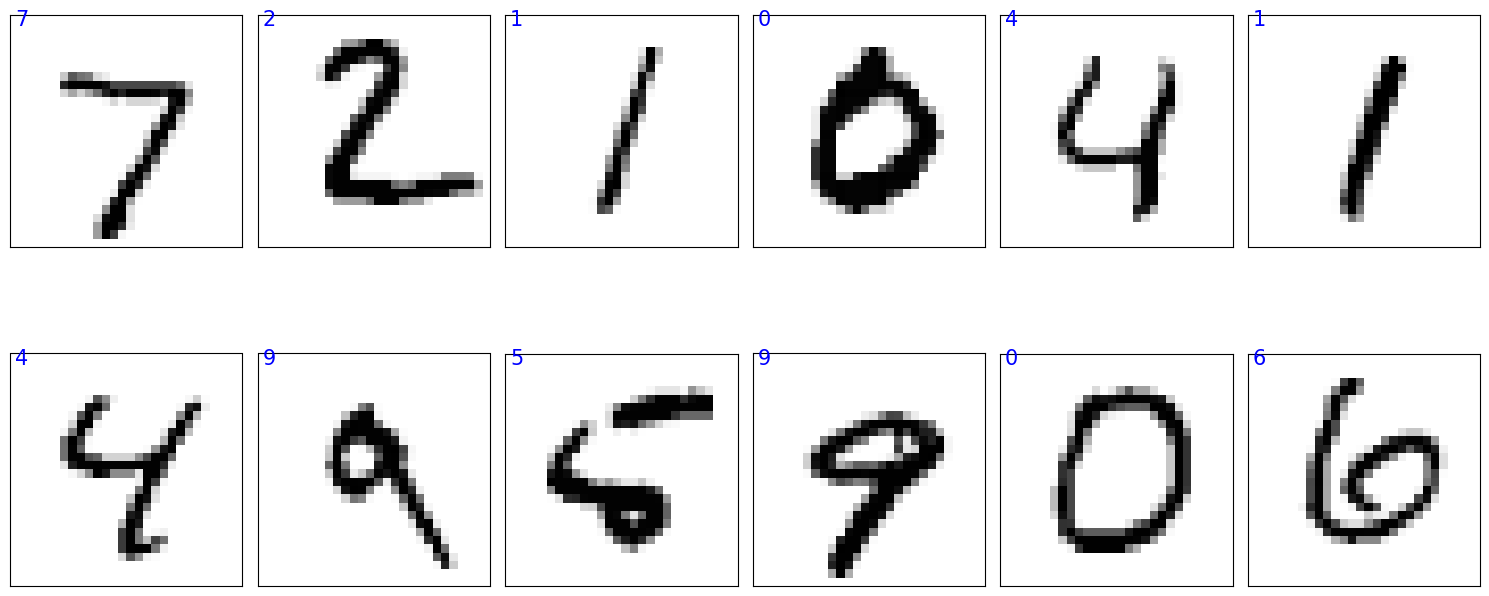

In [34]:
# Crear una figura para mostrar 12 ejemplos de predicciones
fig = plt.figure(figsize=(15,8))

# Mostrar 12 imágenes con sus predicciones
for i in range(12):
    # Crear un subplot para cada imagen
    ax = fig.add_subplot(2, 6, i+1)
    
    # Eliminar los ticks de los ejes
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Mostrar la imagen en escala de grises
    ax.imshow(X_test[i,:,:,0], cmap="Greys")
    
    # Agregar el texto con la predicción
    ax.text(0.9, 0.1, 
           "{}".format(pd[i]), 
           size=15, 
           color="blue",
           ha="center",
           va="center")

# Ajustar el layout y mostrar la figura
plt.tight_layout()
plt.show()

In [36]:
# Importar el módulo os para operaciones del sistema de archivos
import os

# Crear el directorio 'models' si no existe
if not os.path.exists("models"):
    os.mkdir("models")

# Guardar el modelo en formato h5
model.save("models/mnist_CNN.h5")

In [37]:
# Importar keras
import keras

# Cargar el modelo guardado
new_model = keras.models.load_model("models/mnist_CNN.h5")

# Mostrar el resumen de la arquitectura del modelo
new_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv_1 (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv_2 (Conv2D)                      │ (None, 14, 14, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       3,212,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,274,124 (12.49 MB)

 Trainable params: 3,274,122 (12.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [38]:
# Realizar predicciones con el modelo cargado
preds = new_model.predict(X_test)

# Mostrar la forma de las predicciones
print(preds.shape)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
(10000, 10)
